# Intro Tutorial on Relation Extraction from News Articles

## Part I: Preprocessing

In this notebook, we'll preprocess several documents using `Snorkel` utilities, parsing them into a simple hierarchy of component parts of our input data--which we refer to as _contexts_--as well as extracting standard linguistic features from each context.

In this example, we will extract two types of contexts, represented as `Context` subclasses: `Document` and constituent `Sentence` objects.  In particular, we'll do this using [CoreNLP](http://stanfordnlp.github.io/CoreNLP/), which will also extract a number of standard linguistic features which will be used downstream.

All of this preprocessed input data will be saved to a database.  In Snorkel, if no database is specified, then a SQLite database is created by default- so no setup is needed here!

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from snorkel import SnorkelSession
session = SnorkelSession()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading the `Corpus`

First, we will load and pre-process the corpus, storing it for convenience in a `Corpus` object

### Configuring a `DocParser`

We'll start by defining a `DocParser` class to read in Pubmed abstracts from [Pubtator]([Pubtator](http://www.ncbi.nlm.nih.gov/CBBresearch/Lu/Demo/PubTator/index.cgi)), where they are stored along with "gold" (i.e. hand-annotated by experts) *chemical* and *disease mention* annotations. We'll use the `XMLDocParser` class, which allows us to use [XPath queries](https://en.wikipedia.org/wiki/XPath) to specify the relevant sections of the XML format.

_Note that we are newline-concatenating text from the title and abstract together for simplicity, but if we wanted to, we could easily extend the `DocParser` classes to preserve information about document structure._

#### TODO: replace zipped files with unzipped and add command here for unzipping

In [2]:
from snorkel.parser import TSVDocParser

doc_parser = TSVDocParser(path='articles-100.tsv')

### Creating a `SentenceParser`

Next, we'll use an NLP preprocessing tool to split the `Document` objects into sentences, tokens, and provide annotations--part-of-speech tags, dependency parse structure, lemmatized word forms, etc.--for these sentences.  Here we use the default `SentenceParser` class.

In [3]:
from snorkel.parser import SentenceParser

sent_parser = SentenceParser()

### Pre-processing & loading the `Corpus`

Finally, we'll put this all together using a `CorpusParser` object, which will execute the parsers and store the results as a `Corpus`:

/Users/bradenhancock/snorkel/snorkel/parser.py:243: UserWarning: CoreNLP parse has diverged from raw document text!
  warnings.warn("CoreNLP parse has diverged from raw document text!")


SKIPPED!
Number of documents: 100
CPU times: user 5.17 s, sys: 151 ms, total: 5.32 s
Wall time: 26.5 s


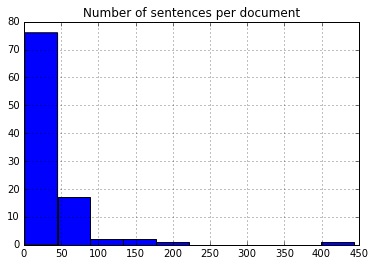

In [4]:
from snorkel.parser import CorpusParser

cp = CorpusParser(doc_parser, sent_parser)
%time corpus = cp.parse_corpus(name='News Training', session=session)

Note that the printed stats are a property of the `Corpus` object, and can be printed again via the `corpus.stats()` method!

In [5]:
doc = corpus.documents[0]
doc

Document 9b28e780-ba48-4a53-8682-7c58c141a1b6

In [6]:
sent = doc.sentences[0]
print sent
print sent.words
print sent.poses

Sentence(Document 9b28e780-ba48-4a53-8682-7c58c141a1b6, 0, u'NEW YORK -- Theatergoers who check out "Beautiful" on tour won\'t get to see Tony winner Jessie Mueller but they may get the next best thing -- someone with her DNA.')
[u'NEW', u'YORK', u'--', u'Theatergoers', u'who', u'check', u'out', u'``', u'Beautiful', u"''", u'on', u'tour', u'wo', u"n't", u'get', u'to', u'see', u'Tony', u'winner', u'Jessie', u'Mueller', u'but', u'they', u'may', u'get', u'the', u'next', u'best', u'thing', u'--', u'someone', u'with', u'her', u'DNA', u'.']
[u'NNP', u'NNP', u':', u'NNS', u'WP', u'VBP', u'RP', u'``', u'JJ', u"''", u'IN', u'NN', u'MD', u'RB', u'VB', u'TO', u'VB', u'NNP', u'NN', u'NNP', u'NNP', u'CC', u'PRP', u'MD', u'VB', u'DT', u'JJ', u'JJS', u'NN', u':', u'NN', u'IN', u'PRP$', u'NN', u'.']


### Saving the `Corpus`
Finally, we persist the parsed corpus in Snorkel's database backend:

In [ ]:
session.add(corpus)
session.commit()

### Repeating for development and test corpora
We will rerun the same operations for the other two CDR corpora: development and test. All we do is change the path that the `XMLMultiDocParser` uses.

In [ ]:
cp.doc_parser.path = 'data/CDR_DevelopmentSet.BioC.xml'
%time corpus = cp.parse_corpus(name='CDR Development', session=session)
session.add(corpus)

In [ ]:
cp.doc_parser.path = 'data/CDR_TestSet.BioC.xml'
%time corpus = cp.parse_corpus(name='CDR Test', session=session)
session.add(corpus)

In [ ]:
session.commit()

In [ ]:
## This cell is just for speeding up automatic testing. You can safely ignore it!
import os
if 'CI' in os.environ:
    from snorkel.models import Corpus
    import random
    for corpus_name in ['CDR Training', 'CDR Development', 'CDR Test']:
        corpus = session.query(Corpus).filter(Corpus.name == corpus_name).one()
        docs = set([d for d in corpus.documents])
        for doc in docs:
            if random.random() > .10:
                corpus.remove(doc)
    session.commit()

Next, in Part 2, we will look at how to extract `Candidate` relations from our saved `Corpus`.